In [1]:
import pandas as pd
import os
import sys
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import shutil
from osgeo import ogr
from collections import OrderedDict
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator


sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws, delete_items
from scripts.utils.cal_crai_calculations import calculate_equal_weighted_index, add_census_tracts
from scripts.utils.cal_crai_plotting import index_plot, plot_region_domain, plot_hazard_score

In [2]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/calcrai_score'
output_folder = 'cal_crai_score_file'

pull_csv_from_directory(bucket_name, aws_dir, output_folder, search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/calcrai_score.


In [3]:
calcrai_score = pd.read_csv(r'cal_crai_score_file/calcrai_score.csv')

In [4]:
keep_columns = ['GEOID', 'hazard_score', 'calcrai_score']
calcrai_plotting_columns = calcrai_score[keep_columns]

# Ensure all values in GEOID are strings
calcrai_plotting_columns['GEOID'] = calcrai_plotting_columns['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
calcrai_plotting_columns['GEOID'] = calcrai_plotting_columns['GEOID'].str.zfill(calcrai_plotting_columns['GEOID'].str.len().max() + 1)

# Display the dataframe
calcrai_plotting_columns

calcrai_plotting_columns

C:\Users\jespi\AppData\Local\Temp\ipykernel_26984\1058555045.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calcrai_plotting_columns['GEOID'] = calcrai_plotting_columns['GEOID'].astype(str)
C:\Users\jespi\AppData\Local\Temp\ipykernel_26984\1058555045.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calcrai_plotting_columns['GEOID'] = calcrai_plotting_columns['GEOID'].str.zfill(calcrai_plotting_columns['GEOID'].str.len().max() + 1)


,GEOID,hazard_score,calcrai_score
0,06001400100,0.691840,0.593840
1,06001400200,0.643412,0.520210
2,06001400300,0.701468,0.384277
3,06001400400,0.643200,0.417900
4,06001400500,0.715325,0.350419
...,...,...,...
9124,06115040902,0.315723,1.320288
9125,06115041001,0.294586,1.037047
9126,06115041002,0.305539,1.342894
9127,06115041101,0.278509,1.337257


In [5]:
# Binning into quartiles
binned_equal_df = calcrai_plotting_columns.copy()

# Define the columns to bin
columns_to_bin = [
    'calcrai_score'
]

# Apply qcut to each specified column and print the bin edges
for column in columns_to_bin:
    # Get the bin labels and edges
    binned_equal_df[column + '_quartile'], bin_edges = pd.qcut(
        binned_equal_df[column], 
        q=[0,0.2, 0.4, 0.6, 0.8, 1.0], 
        labels=False,
        # labels=['<20%', '20-40%', '40-60%', '60-80%', '>80%'],
        duplicates='drop', 
        retbins=True
    )
    print(f'Bin edges for {column}: {bin_edges}')

# Show the resulting DataFrame with the binned columns
binned_equal_df = binned_equal_df[['GEOID','calcrai_score_quartile']]
binned_equal_df

Bin edges for calcrai_score: [0.         0.50782468 0.68969808 1.17630724 1.82769235 4.98642604]


,GEOID,calcrai_score_quartile
0,06001400100,1
1,06001400200,1
2,06001400300,0
3,06001400400,0
4,06001400500,0
...,...,...
9124,06115040902,3
9125,06115041001,2
9126,06115041002,3
9127,06115041101,3


In [6]:
# Create a copy and chain the .replace() calls
binned_df_viz = binned_equal_df.copy()
binned_df_viz['calcrai_score_quartile'] = (
    binned_df_viz['calcrai_score_quartile']
    .replace(0, '0-20%')
    .replace(1, '20-40%')
    .replace(2, '40-60%')
    .replace(3, '60-80%')
    .replace(4, '80+%')
)
binned_df_viz.head()

,GEOID,calcrai_score_quartile
0,06001400100,20-40%
1,06001400200,20-40%
2,06001400300,0-20%
3,06001400400,0-20%
4,06001400500,0-20%


In [7]:
merged_df = pd.merge(calcrai_plotting_columns, binned_df_viz, on='GEOID', how='left')
merged_df

,GEOID,hazard_score,calcrai_score,calcrai_score_quartile
0,06001400100,0.691840,0.593840,20-40%
1,06001400200,0.643412,0.520210,20-40%
2,06001400300,0.701468,0.384277,0-20%
3,06001400400,0.643200,0.417900,0-20%
4,06001400500,0.715325,0.350419,0-20%
...,...,...,...,...
9124,06115040902,0.315723,1.320288,60-80%
9125,06115041001,0.294586,1.037047,40-60%
9126,06115041002,0.305539,1.342894,60-80%
9127,06115041101,0.278509,1.337257,60-80%


In [8]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from shapely.geometry import box # type: ignore

census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)
ca_boundaries['GEOID'] = ca_boundaries['GEOID'].astype(str)

In [9]:
# Merge the passed DataFrame with the census boundary data
merged_df = merged_df.merge(ca_boundaries, on='GEOID')
merged_df['geometry'] = merged_df['geometry']
merged_df = gpd.GeoDataFrame(merged_df, geometry='geometry', crs=4269)

In [10]:
la_county = merged_df[merged_df['COUNTYFP'] =='037']

In [81]:
def plot_hazard_score(df, 
                      column_to_plot, 
                      ax=None,
                      custom_text=None,
                      font_size=16,
                      font_color='white',
                      legend = True,
                      plot_title = False,
                      x_ticks = None
                      ):
    '''
    Maps climate hazard scores from any given climate risk scenario. The hazard scores are used in the denominator in the Cal-CRAI calculation.
    
    Parameters
    ----------
    df : DataFrame
        input DataFrame
    column_to_plot : str
        df's climate domain score column
    domain : str
        domain name, will go as the figure title
    savefig : bool
        if True, saves figure using the domain name as the save name
        Default is False
    ax : matplotlib Axes, optional
        Existing Axes to plot on. If None, a new figure and Axes are created.
    '''
    # Check for invalid geometries
    if len(df) == 0:
        print('No valid geometries. Cannot plot.')
        return

    # Set up the figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4.5, 6), layout='compressed')
        created_fig = True
    else:
        fig = ax.figure
        created_fig = False

    # Define the bounding box to exclude (xmin, ymin, xmax, ymax)
    exclusion_box = box(-119, 33, -118, 33.6) 
    #exclusion_box = box(-118.7, 33, -118, 33.6) 

    # Exclude features within the bounding box
    df = df[~df.intersects(exclusion_box)]

    # Plot the data
    df.plot(
        column=column_to_plot,
        ax=ax,
        vmin=0, vmax=1,
        cmap='Blues'
    )

    # Add a colorbar to the figure, tethered to the plot
    if legend:
        cbar_ax = fig.add_axes([0.065, 0.5401, 0.23, 0.01])
        sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=1))
        sm._A = []  # Required for the ScalarMappable
        cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
        cbar.set_label(u'Exposure \u00D7 Loss', fontsize=10)

    # Set title
    if plot_title:
        ax.set_title(plot_title, fontsize=18)

    # Add a single custom text annotation in the center of the plot if provided
    if custom_text:
        # Determine the bounds of the plot
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # Calculate the center of the plot
        x_center = (xlim[0] + xlim[1]) / 2
        y_center = (ylim[0] + ylim[1]) / 2

        # Apply offsets for positioning the text higher and to the right
        x_offset = (xlim[1] - xlim[0]) * 0.08  # Adjust this fraction as needed
        y_offset = (ylim[1] - ylim[0]) * 0.06  # Adjust this fraction as needed

        # Add text with adjusted position
        ax.text(-118.765, 33.7, custom_text, 
                weight='medium', fontsize=font_size, color=font_color, 
                ha='center', va='center', alpha=1)

    # Adjust the tick font size
    ax.tick_params(axis='y', which='major', labelsize= 12)
    ax.tick_params(axis='y', which='minor', labelsize= 12)

    
    
    if x_ticks:
        # Get the current x-axis limits
        xlim = ax.get_xlim()
        
        # Shrink the limits slightly inward
        buffer = (xlim[1] - xlim[0]) * 0.05  # Adjust buffer as needed
        adjusted_xlim = (xlim[0] + buffer, xlim[1] - buffer)
        
        # Generate symmetrical ticks using the adjusted limits
        tick_positions = np.linspace(adjusted_xlim[0], adjusted_xlim[1], x_ticks)
        
        # Round the tick labels to the nearest tenth
        rounded_labels = [round(tick, 1) for tick in tick_positions]
        
        # Set the ticks and corresponding labels
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(rounded_labels)

    # Display the plot if a new figure was created
    if created_fig:
        plt.show()


In [83]:
def index_plot(df, 
               column, 
               plot_title=False, 
               save_name=None, 
               vmin=-3, 
               vmax=3,
               custom_text=None,  # Text to place in the center of the plot
               font_size=16,
               font_color='white',
               set_legend = True,
               legend_position='upper right',  # Legend position
               legend_bbox=(1, 1),
               x_ticks = None,
               ax=None):
    '''
    Maps the Cal-CRAI index for the entire state with an optional central custom text annotation.
    '''

    # Set up the figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4.5, 6), layout='compressed')
        created_fig = True
    else:
        created_fig = False

    # Define the bounding box to exclude (xmin, ymin, xmax, ymax)
    exclusion_box = box(-119, 33, -118, 33.6) 
    #exclusion_box = box(-118.7, 33, -118, 33.6) 

    # Exclude features within the bounding box
    df = df[~df.intersects(exclusion_box)]    

    # Check plot type and set plotting parameters accordingly
    if set_legend:
        df.plot(column=column, ax=ax, legend=True, cmap='YlGnBu', categorical=True,
                legend_kwds={
                    'loc': legend_position,
                    'bbox_to_anchor': legend_bbox,
                    'title': "Composite Resilience"
                })
    else:
        df.plot(column=column, ax=ax, legend=False, cmap='YlGnBu', categorical=True)


    # Add a single custom text annotation in the center of the plot if provided
    if custom_text:
        # Determine the bounds of the plot
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        # Calculate the center of the plot
        x_center = (xlim[0] + xlim[1]) / 2
        y_center = (ylim[0] + ylim[1]) / 2

        # Apply offsets for positioning the text higher and to the right
        x_offset = (xlim[1] - xlim[0]) * 0.08  # Adjust this fraction as needed
        y_offset = (ylim[1] - ylim[0]) * 0.06  # Adjust this fraction as needed

        # Add text with adjusted position
        ax.text(-118.76, 33.7, custom_text, 
                weight='medium', fontsize=font_size, color=font_color, 
                ha='center', va='center', alpha=1)
    
    if plot_title:
        ax.set_title(plot_title, fontsize=18)

    ax.yaxis.set_visible(False)
    
    if x_ticks:
        # Get the current x-axis limits
        xlim = ax.get_xlim()
        
        # Shrink the limits slightly inward
        buffer = (xlim[1] - xlim[0]) * 0.05  # Adjust buffer as needed
        adjusted_xlim = (xlim[0] + buffer, xlim[1] - buffer)
        
        # Generate symmetrical ticks using the adjusted limits
        tick_positions = np.linspace(adjusted_xlim[0], adjusted_xlim[1], x_ticks)
        
        # Round the tick labels to the nearest tenth
        rounded_labels = [round(tick, 1) for tick in tick_positions]
        
        # Set the ticks and corresponding labels
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(rounded_labels)
        
    # Save figure if required
    if save_name and created_fig:
        fig.savefig(f'{save_name}.png', dpi=300, bbox_inches='tight')  # Save the figure

    if created_fig:
        plt.show()  # Show the plot


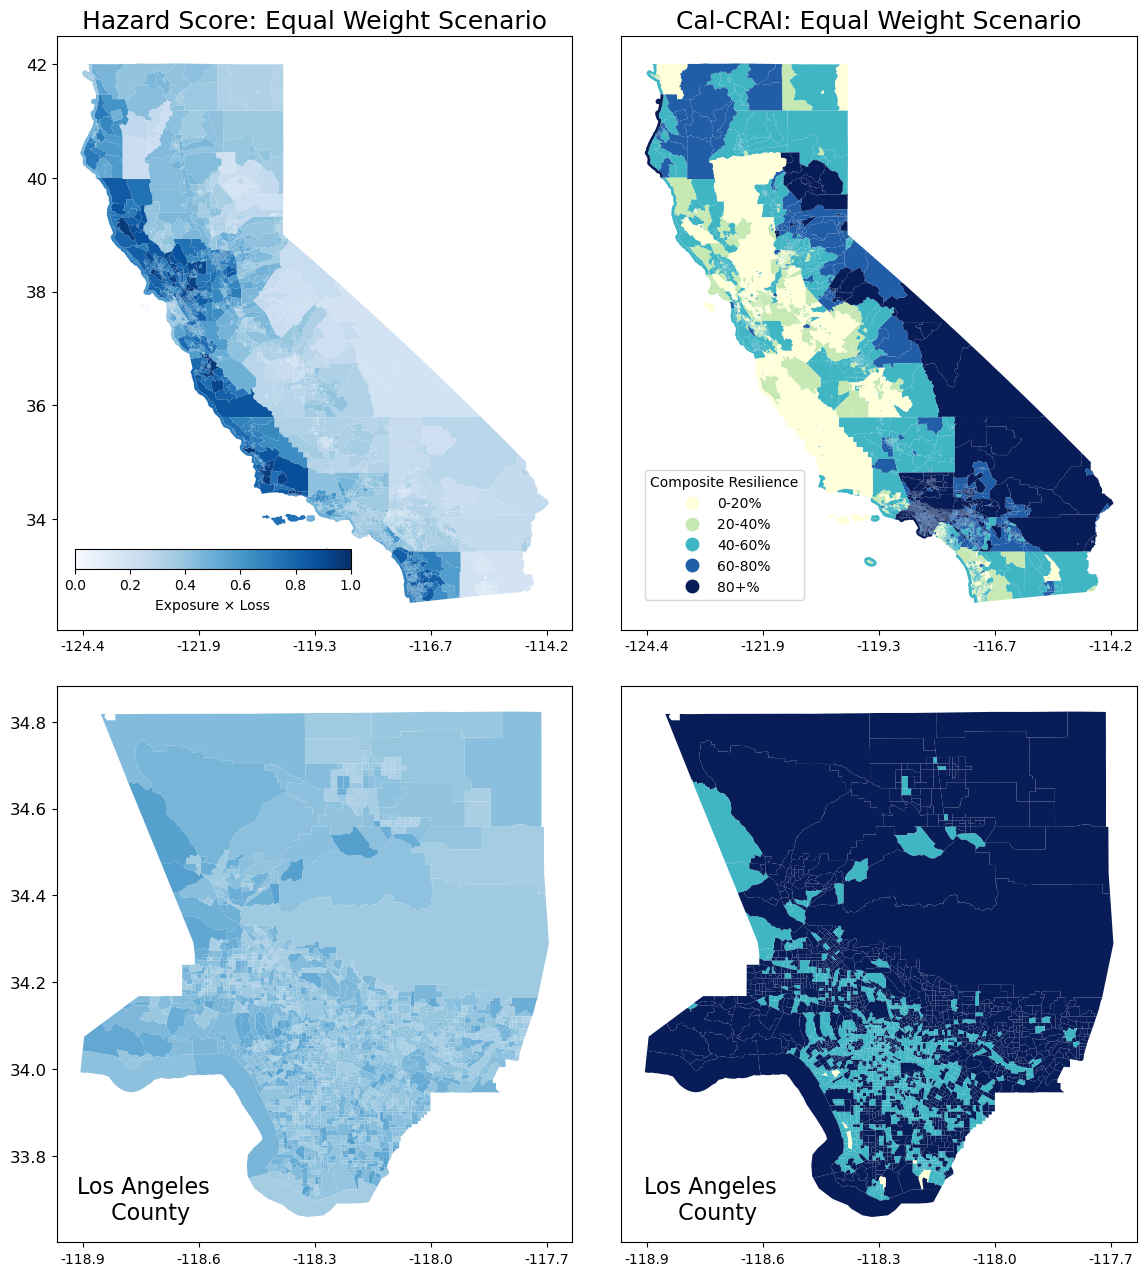

In [84]:
# Create the figure and GridSpec object
fig = plt.figure(figsize=(12, 20))  # Adjust overall figure size
gs = GridSpec(2, 2, height_ratios=[1, 1], wspace=0.095, hspace=-0.46)  # Adjust spacing

# Top-left subplot (hazard score)
ax0 = fig.add_subplot(gs[0, 0])
plot_hazard_score(merged_df, column_to_plot='hazard_score', plot_title='Hazard Score: Equal Weight Scenario',
                x_ticks=5,
                ax=ax0)

# Top-right subplot (index plot)
ax1 = fig.add_subplot(gs[0, 1])
index_plot(
    df=merged_df, 
    column='calcrai_score_quartile', 
    set_legend=True, 
    legend_position='center', 
    legend_bbox=(0.2, 0.16),  # Adjust coordinates for exact placement
    font_size=15,
    plot_title='Cal-CRAI: Equal Weight Scenario',
    x_ticks=5,
    ax=ax1
)

# Bottom-left subplot (LA hazard score)
ax2 = fig.add_subplot(gs[1, 0])
plot_hazard_score(la_county, column_to_plot='hazard_score', ax=ax2, legend=False,
                  x_ticks=5,  custom_text='Los Angeles \n County', font_color='black') #plot_title='Hazard Score: Los Angeles',

# Bottom-right subplot (LA index plot)
ax3 = fig.add_subplot(gs[1, 1])
index_plot(la_county, 'calcrai_score_quartile', save_name='binned equal weight', 
    vmin=0, vmax=5, ax=ax3, set_legend=False, x_ticks=5, custom_text='Los Angeles \n County', font_color='black') #plot_title='Cal-CRAI: Los Angeles',

# Adjust spacing to reduce white space
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

# Save the figure as a PNG file
fig.savefig('CalCRAI_subplot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()